## Data Extraction and Preparation

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Initialize Spark Session
spark = SparkSession.builder.appName("CreditRiskAssessment").getOrCreate()

# Load the CSV file with proper header handling
file_path = "dbfs:/FileStore/tables/creditrisk/credit_card.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop the first column ('Unnamed: 0') if it is not relevant
data = data.drop('Unnamed: 0')

# Show and verify schema
data.show(5, truncate=False)
data.printSchema()

# Cast necessary columns to numeric types
for column in data.columns:
    if column != "Y":  # Assuming 'Y' is the target column
        data = data.withColumn(column, col(column).cast("double"))
data = data.withColumn("Y", col("Y").cast("integer"))

# Handle missing or invalid values
data = data.na.fill(0)

# Feature engineering: Select all columns except the target column
target_column = "Y"
feature_columns = [col for col in data.columns if col != target_column]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_data = scaler.fit(data).transform(data)

# Inspect the processed data
scaled_data.select("scaled_features", target_column).show(5)




+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|_c0|X1       |X2 |X3       |X4      |X5 |X6   |X7   |X8   |X9   |X10  |X11  |X12      |X13      |X14      |X15      |X16      |X17      |X18     |X19     |X20     |X21     |X22     |X23     |Y                         |
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|ID |LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
|1  |20000    |2  |2        |1       |24 |2    |2    |-1   |-1   |-2   |-2   |3913     |3102     |689      |0        |0 

## EDA

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


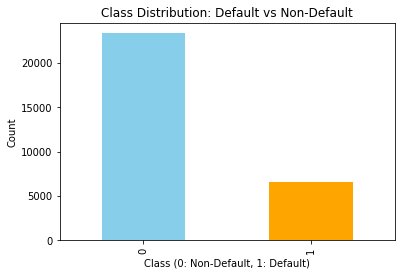

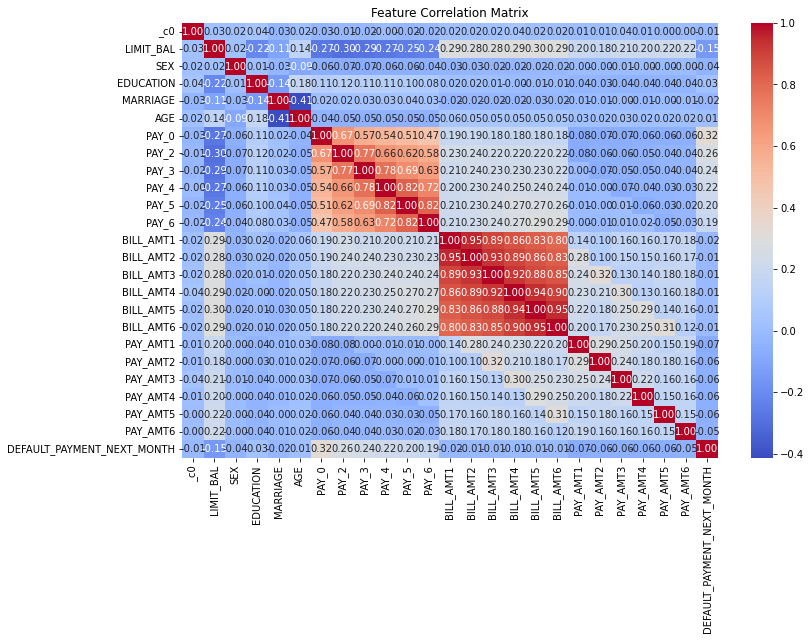

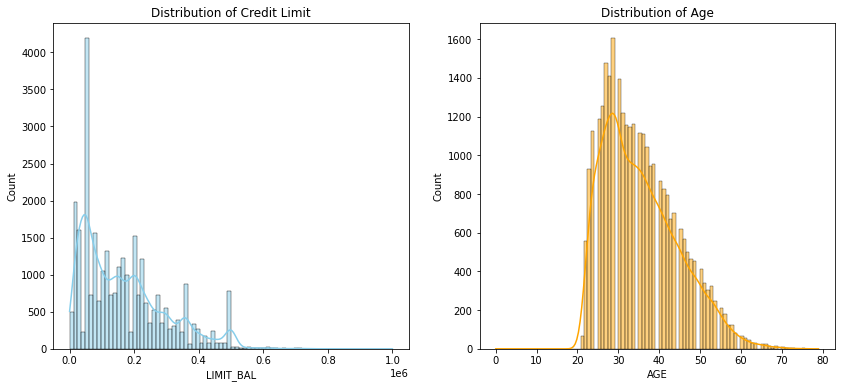

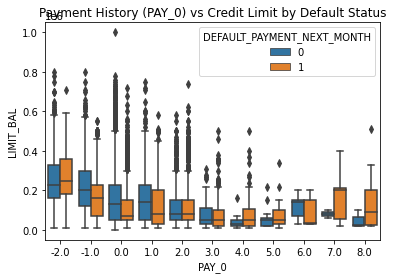

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas for visualization
data_pd = data.toPandas()


data_pd.rename(columns={
    'Unnamed: 0': 'ID',              # Identifier
    'X1': 'LIMIT_BAL',               # Amount of credit limit
    'X2': 'SEX',                     # Gender (1 = male, 2 = female)
    'X3': 'EDUCATION',               # Education level (1 = graduate, 2 = university, etc.)
    'X4': 'MARRIAGE',                # Marital status (1 = married, 2 = single, etc.)
    'X5': 'AGE',                     # Age of the individual
    'X6': 'PAY_0',                   # Repayment status in September
    'X7': 'PAY_2',                   # Repayment status in August
    'X8': 'PAY_3',                   # Repayment status in July
    'X9': 'PAY_4',                   # Repayment status in June
    'X10': 'PAY_5',                  # Repayment status in May
    'X11': 'PAY_6',                  # Repayment status in April
    'X12': 'BILL_AMT1',              # Bill amount in September
    'X13': 'BILL_AMT2',              # Bill amount in August
    'X14': 'BILL_AMT3',              # Bill amount in July
    'X15': 'BILL_AMT4',              # Bill amount in June
    'X16': 'BILL_AMT5',              # Bill amount in May
    'X17': 'BILL_AMT6',              # Bill amount in April
    'X18': 'PAY_AMT1',               # Payment amount in September
    'X19': 'PAY_AMT2',               # Payment amount in August
    'X20': 'PAY_AMT3',               # Payment amount in July
    'X21': 'PAY_AMT4',               # Payment amount in June
    'X22': 'PAY_AMT5',               # Payment amount in May
    'X23': 'PAY_AMT6',               # Payment amount in April
    'Y': 'DEFAULT_PAYMENT_NEXT_MONTH'  # Target variable (1 = default, 0 = no default)
}, inplace=True)


# 1. Class Distribution
class_counts = data_pd['DEFAULT_PAYMENT_NEXT_MONTH'].value_counts()
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution: Default vs Non-Default")
plt.xlabel("Class (0: Non-Default, 1: Default)")
plt.ylabel("Count")
plt.show()

# 2. Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data_pd.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# 3. Distribution of Credit Limit and Age
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_pd['LIMIT_BAL'], kde=True, color="skyblue")
plt.title("Distribution of Credit Limit")

plt.subplot(1, 2, 2)
sns.histplot(data_pd['AGE'], kde=True, color="orange")
plt.title("Distribution of Age")
plt.show()

# 4. Relationship Between Payment History and Default
sns.boxplot(data=data_pd, x='PAY_0', y='LIMIT_BAL', hue='DEFAULT_PAYMENT_NEXT_MONTH')
plt.title("Payment History (PAY_0) vs Credit Limit by Default Status")
plt.show()


## Model Training

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split the data into training and test sets
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression Model
# Train logistic regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Y")
lr_model = lr.fit(train_data)

# Evaluate the model
predictions_lr = lr_model.transform(test_data)

# Calculate ROC-AUC
evaluator = BinaryClassificationEvaluator(labelCol="Y", metricName="areaUnderROC")
roc_auc_lr = evaluator.evaluate(predictions_lr)
print(f"Logistic Regression ROC-AUC: {roc_auc_lr}")


# XGBoost Model
from pyspark.ml.classification import GBTClassifier

# Train XGBoost-like Gradient Boosting Model
xgb = GBTClassifier(featuresCol="scaled_features", labelCol="Y", maxIter=50)
xgb_model = xgb.fit(train_data)

# Evaluate the model
predictions_xgb = xgb_model.transform(test_data)

# Calculate ROC-AUC
roc_auc_xgb = evaluator.evaluate(predictions_xgb)
print(f"XGBoost ROC-AUC: {roc_auc_xgb}")


Logistic Regression ROC-AUC: 0.7238739895589787
XGBoost ROC-AUC: 0.7843667643192284


## SHAP for Interpretability

In [0]:
# Install shap library
%pip install shap


Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Python interpreter will be restarted.


In [0]:
test_data

Out[9]: DataFrame[_c0: double, X1: double, X2: double, X3: double, X4: double, X5: double, X6: double, X7: double, X8: double, X9: double, X10: double, X11: double, X12: double, X13: double, X14: double, X15: double, X16: double, X17: double, X18: double, X19: double, X20: double, X21: double, X22: double, X23: double, Y: int, features: vector, scaled_features: vector]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field scaled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/shap/explainers/_tree.py:360: UserWarning: check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning
  warnings.warn(


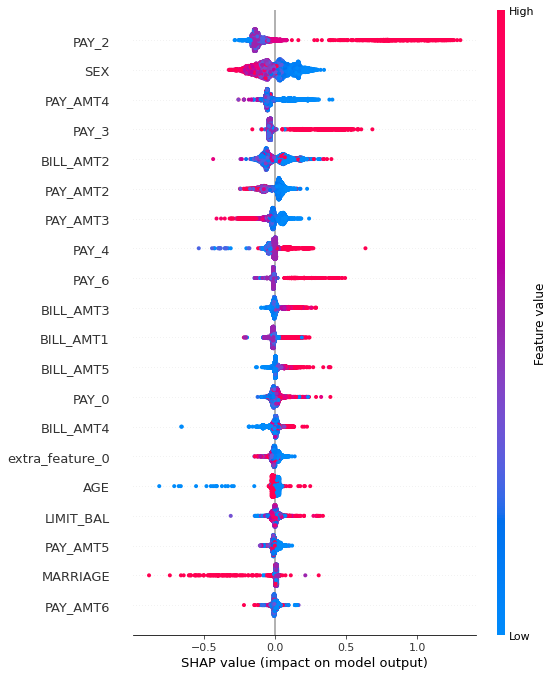

In [0]:
import pandas as pd
import numpy as np
import shap

feature_names = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

# Convert Spark DataFrame to Pandas DataFrame
pandas_data = test_data.select("scaled_features", "Y").toPandas()

# Unpack DenseVector into individual feature columns
features_array = np.array(pandas_data["scaled_features"].tolist())

if features_array.shape[1] != len(feature_names):
    extra_features = [f"extra_feature_{i}" for i in range(features_array.shape[1] - len(feature_names))]
    feature_names.extend(extra_features)

# Create a Pandas DataFrame for features
pandas_features = pd.DataFrame(features_array, columns=feature_names)
pandas_features["Y"] = pandas_data["Y"]

# Prepare data for SHAP (excluding the target column)
X = pandas_features[feature_names]

# Using xgb_model for SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X)

# Visualize SHAP summary
shap.summary_plot(shap_values, X)
